<a href="https://colab.research.google.com/github/mitkrieg/citibike-timeseries/blob/main/fbprophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from fbprophet import Prophet
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd ..
% ls

/
bin/      dev/     lib/    mnt/   run/    sys/                usr/
boot/     etc/     lib32/  opt/   sbin/   tensorflow-1.15.2/  var/
content/  gdrive/  lib64/  proc/  srv/    tmp/
datalab/  home/    media/  root/  swift/  tools/


# Inital 2 Week model

In [5]:
df = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/train_ts.pickle','rb'))
df_test = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/test_ts.pickle','rb'))

In [6]:
m = Prophet(growth = 'flat',daily_seasonality=True, weekly_seasonality=True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [7]:
future = m.make_future_dataframe(periods = 14*24, freq='H')

In [8]:
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,12.914824,6.603882,19.597265
1,2018-06-17 01:00:00,12.377725,5.317418,18.513566
2,2018-06-17 02:00:00,12.222265,6.087002,18.428254
3,2018-06-17 03:00:00,12.534084,6.118200,19.069317
4,2018-06-17 04:00:00,12.831202,6.765177,19.430640
...,...,...,...,...
667,2018-07-14 19:00:00,11.790824,5.345262,18.098863
668,2018-07-14 20:00:00,13.298568,6.768679,19.696704
669,2018-07-14 21:00:00,13.889246,7.460077,20.420183
670,2018-07-14 22:00:00,13.877810,6.998284,20.251326


In [9]:
train_ts = df.set_index('ds')
forcast_ts = forcast.set_index('ds')
test_ts = df_test.set_index('ds')

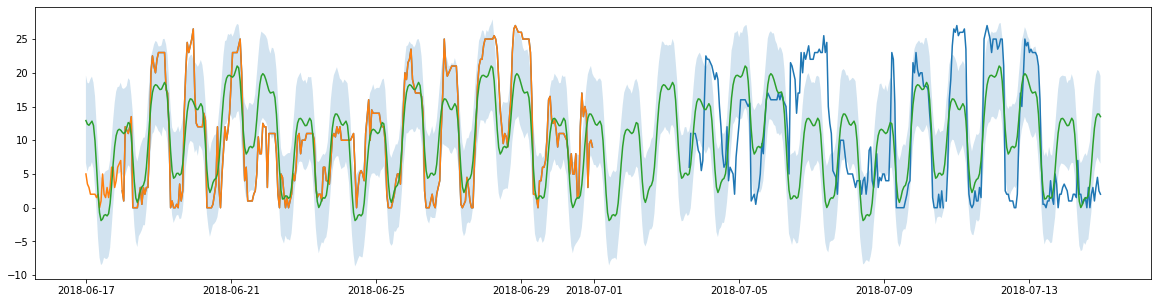

In [10]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test_ts,label='test')
ax.plot(train_ts,label='train')
ax.plot(forcast_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
train_rmse = mean_squared_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'],
                   squared=False)

test_rmse = mean_squared_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
                               squared=False)

train_mae = mean_absolute_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'])

test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 5.0408323291500325
Train MAE:  4.122646416308141

Test RMSE: 7.7349786684867565
Test MAE:  6.226711176838252


OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

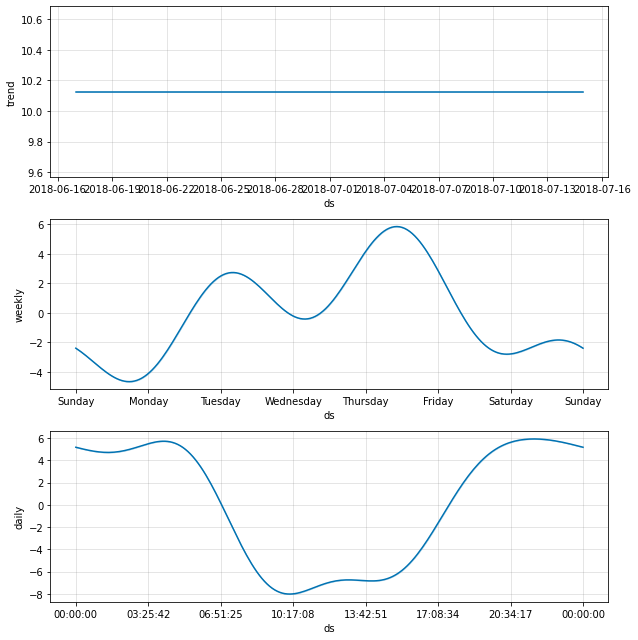

In [13]:
m.plot_components(forcast);
m.seasonalities

In [14]:
%cd /gdrive/MyDrive/Flatiron/Capstone/

/gdrive/MyDrive/Flatiron/Capstone


In [15]:
from fbprophet.diagnostics import performance_metrics, cross_validation
from station import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [15]:
year_2018 = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/historical.pickle','rb'))

In [16]:
station_3172 = year_2018.loc[3172]
availbikes = station_3172.reset_index()[['date_time','avail_bikes']]
availbikes.rename(columns={'date_time':'ds','avail_bikes':'y'}, inplace=True)
availbikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11122 entries, 0 to 11121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11122 non-null  datetime64[ns]
 1   y       11122 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 173.9 KB


In [17]:
future2 = m.make_future_dataframe(periods=24*180,freq='H')
forcast2 = m.predict(future2)
forcast2[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,12.914824,6.676844,19.259201
1,2018-06-17 01:00:00,12.377725,5.977562,18.583405
2,2018-06-17 02:00:00,12.222265,6.055877,18.846910
3,2018-06-17 03:00:00,12.534084,5.812325,19.442463
4,2018-06-17 04:00:00,12.831202,7.046914,19.405359
...,...,...,...,...
4651,2018-12-27 19:00:00,18.246695,11.744470,24.740091
4652,2018-12-27 20:00:00,19.519478,12.902032,25.446499
4653,2018-12-27 21:00:00,19.869939,13.531986,25.976654
4654,2018-12-27 22:00:00,19.615323,13.348916,26.319418


In [18]:
forcast2_ts = forcast2.set_index('ds')
train2_ts = availbikes.set_index('ds')
train2_ts = train2_ts.resample('H').mean()

(736949.0, 736967.0, -5.0, 45.0)

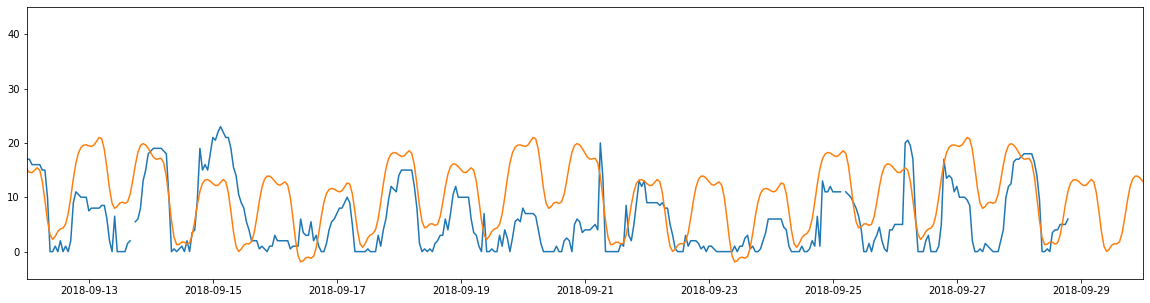

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
#ax.plot(test_ts,label='test')
ax.plot(train2_ts,label='train')
ax.plot(forcast2_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-09-12'),np.datetime64('2018-09-30'),-5,45])

In [20]:
train2_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       7182 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [21]:
forcast2_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4656 entries, 2018-06-17 00:00:00 to 2018-12-27 23:00:00
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   trend                       4656 non-null   float64
 1   yhat_lower                  4656 non-null   float64
 2   yhat_upper                  4656 non-null   float64
 3   trend_lower                 4656 non-null   float64
 4   trend_upper                 4656 non-null   float64
 5   additive_terms              4656 non-null   float64
 6   additive_terms_lower        4656 non-null   float64
 7   additive_terms_upper        4656 non-null   float64
 8   daily                       4656 non-null   float64
 9   daily_lower                 4656 non-null   float64
 10  daily_upper                 4656 non-null   float64
 11  weekly                      4656 non-null   float64
 12  weekly_lower                4656 non-null   float64
 1

In [22]:
train_rmse = mean_squared_error(y_true=train2_ts['2018-06-17':'2018-06-30'],
                   y_pred=forcast_ts.yhat[:'2018-06-30'],
                   squared=False)

test_rmse = mean_squared_error(y_true=train2_ts['2018-06-17':'2018-12-27'].interpolate(),
                               y_pred=forcast2_ts.yhat['2018-06-17':'2018-12-27'],
                               squared=False)

train_mae = mean_absolute_error(y_true=train2_ts['2018-06-17':'2018-06-30'],
                   y_pred=forcast_ts.yhat[:'2018-06-30'])

test_mae = mean_absolute_error(y_true=train2_ts['2018-06-17':'2018-12-27'].interpolate(),
                               y_pred=forcast2_ts.yhat['2018-06-17':'2018-12-27'])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 5.0408323291500325
Train MAE:  4.122646416308141

Test RMSE: 8.357052365352889
Test MAE:  6.75773034824516


# Year Model

In [32]:
year_model = Prophet(growth= 'flat',yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=True)
year_model.fit(availbikes)

In [33]:
future = year_model.make_future_dataframe(periods = 24*119,freq='H')
forcast = year_model.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:26:00,10.673678,0.659084,19.765427
1,2018-01-01 00:59:00,10.706829,0.936477,19.781801
2,2018-01-01 01:32:00,10.762911,0.675660,20.010207
3,2018-01-01 02:04:00,10.876172,1.575445,19.355443
4,2018-01-01 02:38:00,11.086393,1.518494,20.380963
...,...,...,...,...
13973,2019-04-29 19:30:00,10.008218,0.657090,18.831676
13974,2019-04-29 20:30:00,11.354342,1.896003,21.034741
13975,2019-04-29 21:30:00,12.265276,2.688211,21.354610
13976,2019-04-29 22:30:00,12.876908,3.715432,22.630076


In [34]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

(736862.0, 736889.0, -5.0, 45.0)

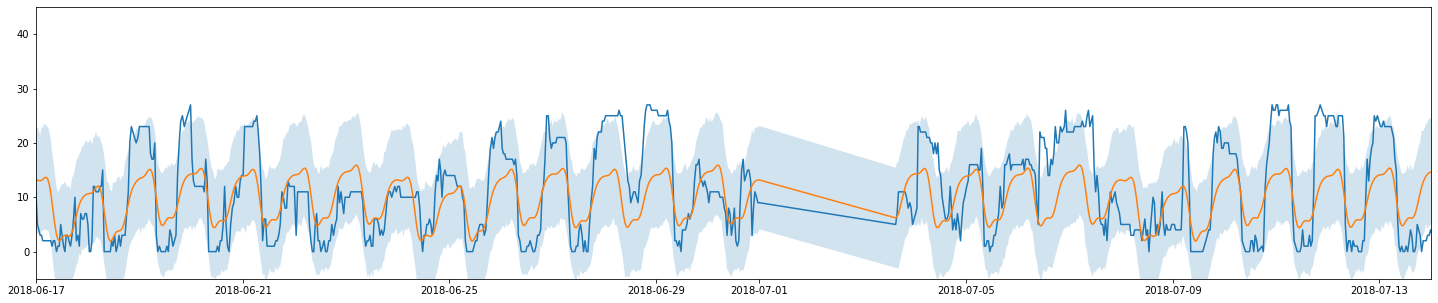

In [35]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [36]:
train_rmse = mean_squared_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 7.416670263669405
Train MAE:  6.1906391045583264



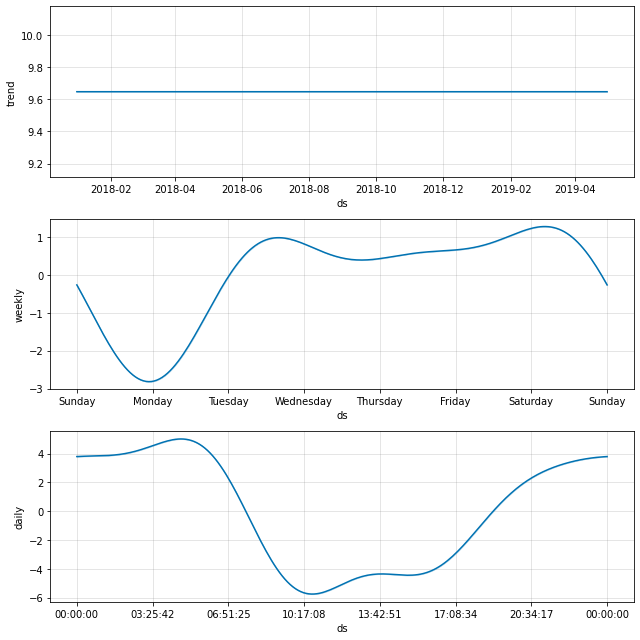

In [37]:
year_model.plot_components(forcast);

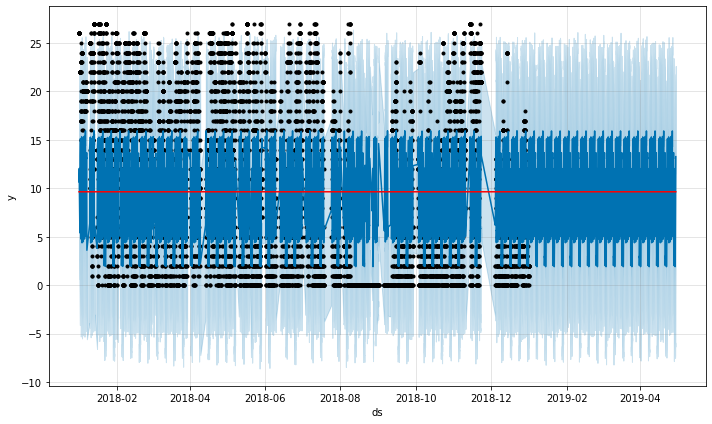

In [38]:
from fbprophet.plot import add_changepoints_to_plot
fig = year_model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), m, forcast)

# Custom Season Model

In [39]:
decomp_prophet = Prophet(growth='flat')
decomp_prophet.add_seasonality(name='daily',period=1,fourier_order=4, prior_scale=10)
decomp_prophet.add_seasonality(name='weekly',period=7,fourier_order=3, prior_scale=10)
decomp_prophet.fit(availbikes)

future = decomp_prophet.make_future_dataframe(periods = 24*119,freq='H')
forcast = decomp_prophet.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:26:00,10.673678,0.555156,19.818225
1,2018-01-01 00:59:00,10.706829,1.145605,20.533629
2,2018-01-01 01:32:00,10.762911,1.202884,20.135103
3,2018-01-01 02:04:00,10.876172,2.096803,20.912904
4,2018-01-01 02:38:00,11.086393,2.413996,20.150637
...,...,...,...,...
13973,2019-04-29 19:30:00,10.008218,0.178173,19.457519
13974,2019-04-29 20:30:00,11.354342,1.631657,20.449228
13975,2019-04-29 21:30:00,12.265276,2.886047,21.813759
13976,2019-04-29 22:30:00,12.876908,3.975118,22.317644


(736862.0, 736889.0, -5.0, 45.0)

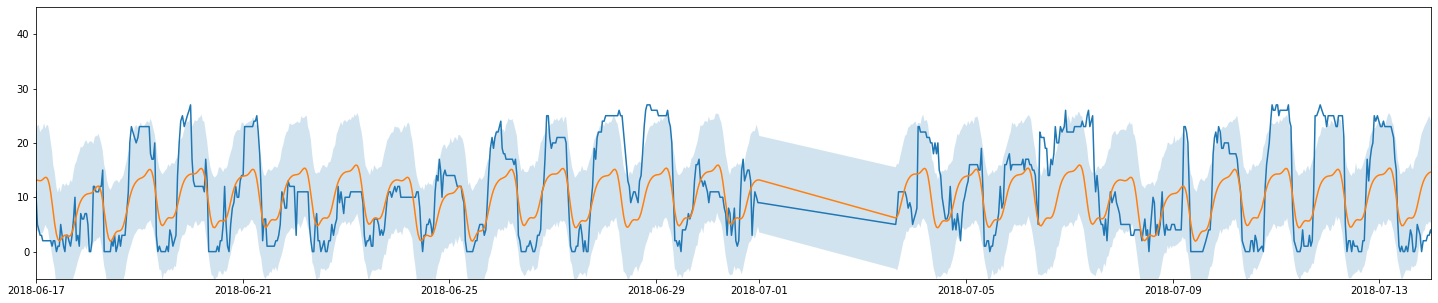

In [40]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [41]:
train_rmse = mean_squared_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 7.416670263669405
Train MAE:  6.190639104558449



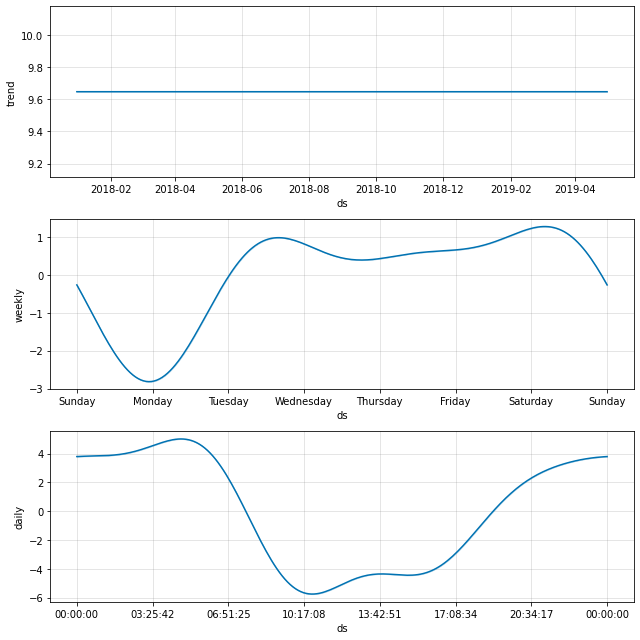

In [42]:
decomp_prophet.plot_components(forcast);

In [43]:
station_3176 = year_2018.loc[3167]['2018-02-01':]

# Cross Validation and Grid Search

In [153]:
import itertools

In [156]:
params = {
    'change_point_prior_scale':[.001,.01,.1,.5,1],
    'seasonality_prior_scale':[.01,.1,1,5,10]
}

combs = [dict(zip(params.keys(),value)) for value in itertools.product(*params.values())]
print('Number of searches: ',len(combs))

Number of searches:  25


In [168]:
cv = cross_validation(year_model, initial = '2160 hours', period='2160 hours',horizon='720 hours',
                      parallel='processes')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-06-04 23:30:00 and 2018-12-01 23:30:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3809811320>


In [169]:
cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-04 23:33:00,16.643535,8.049801,25.465727,12,2018-06-04 23:30:00
1,2018-06-05 00:12:00,16.832241,8.817397,26.489208,7,2018-06-04 23:30:00
2,2018-06-05 00:45:00,16.980963,7.854410,26.032360,3,2018-06-04 23:30:00
3,2018-06-05 01:17:00,17.132275,8.506708,25.928463,3,2018-06-04 23:30:00
4,2018-06-05 01:53:00,17.334286,8.898916,26.352839,7,2018-06-04 23:30:00
...,...,...,...,...,...,...
2604,2018-12-31 20:22:00,11.654493,2.379682,21.088009,2,2018-12-01 23:30:00
2605,2018-12-31 21:13:00,12.514262,3.358528,22.042340,2,2018-12-01 23:30:00
2606,2018-12-31 21:54:00,13.023321,3.662264,23.390542,2,2018-12-01 23:30:00
2607,2018-12-31 22:46:00,13.500269,4.284290,23.254486,2,2018-12-01 23:30:00


In [170]:
performance = performance_metrics(cv)
performance.sort_values('rmse',ascending=True)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
1785,22 days 18:59:00,26.532281,5.150950,4.404377,0.937726,0.961538
1783,22 days 18:34:00,26.571964,5.154800,4.406842,0.937726,0.961538
1786,22 days 19:17:00,26.593592,5.156897,4.415884,0.937726,0.961538
1782,22 days 18:15:00,26.663834,5.163704,4.416123,0.940020,0.961538
1784,22 days 18:37:00,26.691431,5.166375,4.426670,0.940020,0.961538
...,...,...,...,...,...,...
122,5 days 07:51:00,88.645415,9.415169,7.968784,4.569476,0.642308
126,5 days 09:27:00,88.720648,9.419164,7.988121,4.704135,0.642308
128,5 days 10:04:00,88.745789,9.420498,7.999855,5.109670,0.642308
123,5 days 08:15:00,88.747861,9.420608,7.973413,4.569476,0.642308


# Apply Inital Week 2 to all stations

In [23]:
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
station_mat.columns = [str(col) for col in station_mat.columns]
station_drop = list(station_mat['2018-06-17':'2018-06-30'].isna().sum().sort_values(ascending=False).head(45).index)
station_drop.append('3259')

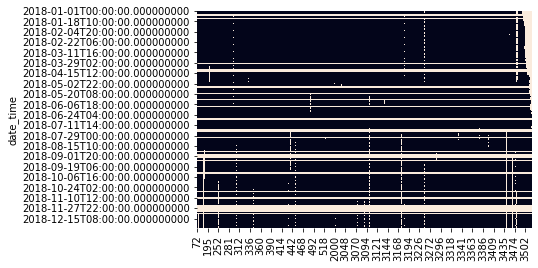

In [24]:
station_mat = station_mat.drop(columns=station_drop)
sns.heatmap(station_mat.isnull(),cbar=False)

In [25]:
station_mat

,72,79,82,83,119,120,127,128,143,144,146,150,151,152,157,161,164,167,168,173,174,195,212,216,217,223,228,229,232,236,237,238,239,241,242,243,244,245,247,248,...,3462,3463,3466,3467,3469,3472,3474,3476,3477,3478,3479,3481,3483,3486,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,12.0,7.0,5.0,10.5,12.5,4.0,15.0,8.0,3.0,6.0,8.0,3.5,0.0,7.0,17.0,0.0,6.0,10.0,9.0,7.0,18.0,0.0,7.0,13.0,10.0,6.0,19.5,4.0,7.0,10.0,7.0,20.0,10.5,7.0,4.0,4.0,...,4.0,22.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,NaN,7.0,NaN,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,12.0,7.0,3.0,9.0,13.0,4.0,15.0,9.0,3.0,5.0,9.0,4.0,0.0,7.0,14.0,0.0,7.0,9.0,9.0,7.0,18.0,0.0,7.0,14.0,10.0,4.0,20.0,4.0,7.0,10.0,7.0,20.0,11.0,7.0,5.0,4.0,...,4.0,22.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,NaN,7.0,NaN,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,12.0,7.0,3.0,9.0,13.0,4.0,14.0,9.0,2.0,5.0,9.0,4.0,0.0,8.0,12.0,0.0,8.0,9.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.5,7.0,10.0,7.0,20.0,11.5,7.0,5.0,4.0,...,4.0,23.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,NaN,7.0,NaN,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,0.5,5.0,9.0,3.0,7.5,8.0,12.0,0.0,10.0,10.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.0,7.0,10.0,7.0,20.0,12.0,7.0,5.0,4.0,...,4.0,23.0,17.5,14.0,1.0,11.0,0.0,0.0,15.0,16.0,NaN,6.5,NaN,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,1.0,5.0,9.0,3.0,15.0,8.0,13.0,0.0,9.0,10.0,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,4.0,6.0,10.0,7.0,20.0,12.0,7.0,2.0,4.0,...,4.0,23.0,17.0,13.0,1.0,11.0,0.0,0.0,15.0,16.0,NaN,6.0,NaN,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,14.0,26.0,25.0,NaN,8.0,3.0,27.0,28.0,18.0,14.0,32.0,14.0,30.0,NaN,14.0,35.0,10.0,12.0,34.0,0.0,21.0,36.0,27.0,5.0,10.0,30.0,29.0,18.0,0.0,27.0,36.0,24.0,14.0,15.0,10.0,27.0,13.0,11.0,18.0,19.0,...,4.0,31.0,NaN,38.0,3.0,39.0,34.0,NaN,9.0,12.0,NaN,4.0,2.0,27.0,20.0,27.0,14.0,4.0,3.0,22.0,20.0,16.0,19.0,17.0,2.0,27.0,5.0,26.0,3.0,7.0,11.0,2.0,2.0,8.0,20.0,8.0,8.0,17.0,2.0,7.0
2018-12-31 20:00:00,14.0,26.0,24.0,NaN,8.0,4.0,26.0,28.0,18.0,14.0,32.0,13.0,31.0,NaN,14.0,35.0,11.0,13.0,34.0,0.0,21.0,37.0,27.0,5.0,10.0,30.0,29.0,19.0,0.0,27.0,36.0,24.0,15.0,15.0,10.0,27.0,13.0,12.0,18.0,19.0,...,4.0,31.0,NaN,36.0,3.0,39.0,33.0,NaN,9.0,12.0,NaN,4.0,2.0,21.0,20.0,27.0,16.0,4.0,3.0,22.0,20.0,16.0,19.0,17.0,2.0,27.0,5.0,26.0,3.0,8.0,11.0,2.0,2.0,7.0,20.0,8.0,8.0,17.0,2.0,7.0
2018-12-31 21:00:00,14.0,26.0,24.0,NaN,8.0,4.0,26.5,28.0,18.0,14.0,32.0,12.5,29.0,NaN,15.0,35.0,10.0,12.5,34.0,0.0,21.0,37.5,27.0,4.0,10.0,31.0,29.0,19.0,0.0,27.0,35.5,24.0,15.0,15.0,10.0,27.0,13.0,12.0,18.0,19.0,...,4.0,31.0,NaN,37.0,3.0,39.0,34.0,NaN,9.0,12.0,NaN,4.0,2.0,21.0,20.0,27.0,16.0,4.0,3.0,22.0,20.0,16.0,19.0,18.0,2.0,27.0,5.0,26.5,3.0,7.5,11.0,2.0,2.0,7.0,20.0,8.5,8.0,17.0,2.0,8.0


In [26]:
sorted(list(station_mat.isna().sum().sort_values(ascending=False).head(47).index))

['152',
 '161',
 '2001',
 '223',
 '253',
 '298',
 '306',
 '3073',
 '3090',
 '3103',
 '3176',
 '3182',
 '3254',
 '3299',
 '3377',
 '3398',
 '3438',
 '3447',
 '345',
 '3466',
 '3476',
 '3479',
 '3483',
 '3497',
 '3498',
 '3499',
 '3500',
 '3501',
 '3502',
 '3503',
 '3504',
 '3505',
 '3506',
 '3507',
 '3508',
 '3509',
 '3510',
 '3511',
 '3512',
 '3513',
 '3514',
 '433',
 '439',
 '449',
 '484',
 '537',
 '83']

In [33]:
system_forcast = pd.DataFrame()
system_daily = pd.DataFrame()
for col in station_mat.columns:
  #prep station time series for prophet
  station_ts = station_mat[col]['2018-06-17':'2018-06-30'].reset_index().rename(columns={'date_time':'ds',col:'y'})

  #create and fit prophet
  print(col)
  model = Prophet(growth='flat',weekly_seasonality=True,daily_seasonality=True)
  try:
    model.fit(station_ts)
  except:
    print('error at ',col)
    continue

  #predict future
  future = model.make_future_dataframe(periods = 180*24, freq='H')
  forecast = model.predict(future)

  #add to system dataframe
  forecast.rename(columns={'yhat':'yhat_'+col,'daily':'daily_'+col},inplace=True)
  system_forcast['yhat_'+col] = forecast['yhat_'+col]
  system_daily['daily_'+col] = forecast['daily_'+col]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


72


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


79


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


82


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


83


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


119


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


120


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


144


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


150


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


161


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


167


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


168


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


173


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


217


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


228


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


229


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


232


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


237


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


238


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


241


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


244


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


245


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


247


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


248


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


251


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


252


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


253


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


254


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


257


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


260


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


261


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


262


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


264


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


265


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


266


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


270


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


274


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


276


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


278


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


279


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


280


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


281


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


282


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


289


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


295


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


296


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


297


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


301


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


303


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


304


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


306


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


307


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


309


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


310


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


311


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


315


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


316


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


317


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


320


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


321


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


322


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


323


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


326


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


328


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


330


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


331


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


332


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


334


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


337


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


339


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


340


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


341


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


344


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


350


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


351


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


353


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


355


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


358


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


359


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


360


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


361


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


362


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


364


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


365


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


369


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


372


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


373


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


376


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


380


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


382


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


383


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


386


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


387


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


388


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


389


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


390


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


391


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


392


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


394


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


396


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


398


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


400


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


401


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


402


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


405


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


406


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


408


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


409


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


410


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


411


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


416


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


419


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


420


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


422


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


426


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


427


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


432


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


433


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


436


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


437


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


438


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


439


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


440


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


441


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


442


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


443


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


445


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


446


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


448


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


449


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


450


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


457


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


458


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


459


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


460


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


462


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


467


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


468


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


470


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


471


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


472


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


473


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


477


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


479


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


480


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


482


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


484


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


485


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


487


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


490


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


494


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


499


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


500


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


501


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


503


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


504


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


505


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


514


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


516


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


518


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


519


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


520


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


524


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


526


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


528


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


529


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


530


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


532


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


533


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


534


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


536


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


537


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


539


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


540


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


545


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


546


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2001


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2002


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2003


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2005


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2006


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2008


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2009


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2010


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2012


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2021


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2022


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3002


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3042


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3043


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3044


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3046


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3047


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3048


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3049


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3050


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3052


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3053


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3054


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3055


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3056


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3057


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3058


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3059


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3060


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3061


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3062


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3063


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3065


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3068


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3069


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3070


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3071


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3072


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3073


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3075


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3076


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3077


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3078


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3080


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3081


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3082


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3083


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3085


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3086


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3090


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3091


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3092


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3093


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3094


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3100


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3103


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3105


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3107


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3109


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3110


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3112


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3113


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3115


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3116


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3117


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3119


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3120


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3121


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3122


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3124


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3125


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3129


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3130


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3132


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3136


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3137


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3139


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3140


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3141


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3144


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3145


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3148


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3150


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3156


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3158


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3159


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3160


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3161


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3162


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3165


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3167


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3168


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3169


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3170


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3171


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3172


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3173


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3176


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3177


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3178


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3180


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3183


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3186


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3187


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3191


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3192


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3193


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3194


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3196


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3198


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3201


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3202


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3203


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3206


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3207


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3209


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3210


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3214


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3220


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3221


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3226


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3231


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3232


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3241


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3244


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3254


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3256


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3260


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3263


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3270


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3272


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3276


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3277


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3278


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3279


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3280


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3281


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3282


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3284


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3289


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3290


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3292


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3295


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3296


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3297


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3300


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3301


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3303


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3304


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3306


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3307


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3309


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3310


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3311


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3315


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3317


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3318


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3320


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3321


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3322


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3323


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3326


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3328


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3330


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3331


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3332


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3337


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3338


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3339


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3340


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3341


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3344


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3348


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3350


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3351


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3352


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3355


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3358


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3359


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3360


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3361


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3362


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3364


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3365


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3367


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3369


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3370


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3371


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3372


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3373


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3374


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3376


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3378


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3381


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3382


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3383


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3384


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3386


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3387


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3388


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3389


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3390


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3391


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3392


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3394


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3396


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3398


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3400


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3401


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3402


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3404


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3405


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3408


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3409


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3410


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3411


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3413


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3419


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3420


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3422


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3425


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3427


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3429


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3430


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3431


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3437


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3438


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3440


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3443


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3449


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3452


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3457


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3458


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3459


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3462


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3463


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3467


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3472


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3477


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3479


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3489


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3490


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3493


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3494


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3499


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3500


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3501


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3503


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3504


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3505


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3510


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3511


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3512


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3514


In [34]:
system_forcast['date_time'] = pd.to_datetime(forecast.ds) 
system_forcast = system_forcast.set_index('date_time')

,yhat_72,yhat_79,yhat_82,yhat_83,yhat_119,yhat_120,yhat_127,yhat_128,yhat_143,yhat_144,yhat_146,yhat_150,yhat_151,yhat_152,yhat_157,yhat_161,yhat_164,yhat_167,yhat_168,yhat_173,yhat_174,yhat_195,yhat_212,yhat_216,yhat_217,yhat_223,yhat_228,yhat_229,yhat_232,yhat_236,yhat_237,yhat_238,yhat_239,yhat_241,yhat_242,yhat_243,yhat_244,yhat_245,yhat_247,yhat_248,...,yhat_3462,yhat_3463,yhat_3466,yhat_3467,yhat_3469,yhat_3472,yhat_3474,yhat_3476,yhat_3477,yhat_3478,yhat_3479,yhat_3481,yhat_3483,yhat_3486,yhat_3489,yhat_3490,yhat_3491,yhat_3492,yhat_3493,yhat_3494,yhat_3495,yhat_3496,yhat_3497,yhat_3498,yhat_3499,yhat_3500,yhat_3501,yhat_3502,yhat_3503,yhat_3504,yhat_3505,yhat_3506,yhat_3507,yhat_3508,yhat_3509,yhat_3510,yhat_3511,yhat_3512,yhat_3513,yhat_3514
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-17 00:00:00,11.915825,-2.858486,8.630616,25.029877,11.323820,13.453503,20.342602,14.296379,9.037385,9.986100,-1.613490,20.182904,0.655301,0.0,15.216692,21.001071,-9.772669,-2.598296,2.775755,-4.376925,11.715804,-3.389273,4.572716,8.897021,8.836782,6.889567,-14.523436,4.541324,7.657915,26.899911,28.927321,23.409405,-4.797568,11.761389,5.486742,21.819618,19.495978,11.474383,13.798979,-0.056039,...,-7.671300,8.534955,-8.300957,12.408824,11.811340,5.538099,3.143025,0.0,11.564220,13.044411,19.630359,11.821470,11.049429,7.956032,-0.360361,14.844230,19.353547,5.207692,7.051357,3.563334,17.839738,15.473378,16.795511,11.098126,9.355741,5.402933,6.334109,4.134466,6.087663,10.977540,8.381785,9.895079,16.304786,17.665132,14.038296,17.224913,14.415769,14.538398,16.828000,12.551559
2018-06-17 01:00:00,11.162531,-2.788759,8.710584,25.016743,11.041973,12.867374,19.518666,15.070914,9.534274,10.107104,-1.703897,22.293545,0.350818,0.0,14.612480,21.006752,-9.613158,-2.167578,2.055901,-3.660040,12.255011,-2.866275,5.654029,9.454827,9.807003,7.330109,-13.933700,4.285009,7.343259,28.375145,28.664599,22.837377,-4.745305,12.210334,5.668939,21.819020,18.238285,11.656415,13.170164,0.179372,...,-7.949853,9.949670,-7.193814,10.970137,11.807168,7.027573,3.559231,0.0,11.837585,13.835702,19.467723,11.961147,11.159267,7.967996,-0.137578,14.333632,19.621083,5.275891,6.815717,3.471800,18.350527,15.248646,17.166777,11.691118,9.396573,5.623312,6.466350,4.238608,6.163676,11.013729,8.628089,9.490147,15.874886,16.770216,13.819774,16.854093,14.466303,14.850097,16.921525,12.459855
2018-06-17 02:00:00,10.241949,-2.430899,8.942980,25.175118,10.695433,12.417968,19.762793,16.683809,9.540908,10.045285,-1.512998,22.870107,0.937029,0.0,14.397804,21.521846,-8.420786,-1.691430,3.054477,-3.519054,11.749880,-1.439924,6.360251,9.767055,11.212021,7.233609,-12.465257,3.509575,7.198152,28.691291,28.285551,22.310197,-3.634500,12.059213,6.331886,21.494067,17.114771,11.748002,12.925893,0.814124,...,-6.709778,10.993096,-6.121181,10.801783,11.889060,8.277533,5.057170,0.0,12.224220,15.271537,19.394384,11.897949,11.315623,7.649018,0.393948,13.910934,19.763638,5.280934,6.634904,3.366725,18.674037,14.960185,17.410181,11.995402,9.277761,5.789840,6.472633,4.225938,6.115820,11.210286,8.807534,9.221515,15.518669,15.741014,13.540758,16.520560,14.472868,15.048602,16.994836,12.172503
2018-06-17 03:00:00,10.015064,-1.756585,9.245723,25.469093,10.476316,12.343523,20.448519,17.800669,9.037109,9.903414,-1.082830,22.686540,2.093193,0.0,14.196220,22.002513,-7.348573,-1.422468,4.872379,-4.460432,11.405003,-0.578862,6.658217,10.087217,12.048229,7.233087,-11.817741,3.195261,7.668203,27.924155,27.714825,21.960066,-2.294462,11.915955,7.045365,20.340979,17.081826,11.830464,12.842940,1.541741,...,-5.471866,11.255102,-6.200073,11.867276,12.201143,7.812346,6.138634,0.0,12.764733,16.936990,19.350675,11.847399,11.466196,7.110118,0.738648,13.715076,19.867601,5.219889,6.484473,3.169195,18.926667,14.375973,17.331747,12.066943,9.187824,5.780453,6.539584,4.130393,5.983869,11.407580,8.920563,9.179879,15.217377,14.747445,13.287678,16.424366,14.649988,15.104514,17.001902,11.86455

In [36]:
system_daily['date_time'] = pd.to_datetime(forecast.ds) 
system_daily = system_daily.set_index('date_time')

In [37]:
pickle_out = open('/gdrive/MyDrive/Flatiron/Capstone/system_forcast.pickle','wb')
pickle.dump(system_forcast,pickle_out)
pickle_out.close()

pickle_out = open('/gdrive/MyDrive/Flatiron/Capstone/system_daily.pickle','wb')
pickle.dump(system_daily,pickle_out)
pickle_out.close()